In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

file_path = 'data_cleaned.csv'

data = pd.read_csv(file_path)

X = data.drop('charges', axis=1)
y = data['charges']



In [2]:

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.85, random_state=42, stratify=X['smoker'])
# 80% pour train et 20% de test

print("Train set X", X_train.shape)
print("Train set Y", y_train.shape)
print("Test set X", X_test.shape)
print("Test set Y", y_test.shape)

Train set X (1136, 17)
Train set Y (1136,)
Test set X (201, 17)
Test set Y (201,)


In [3]:
# Identifier les colonnes catégories et numériques
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns


# Créer le pipeline pour les features numériques
numerical_pipeline = Pipeline([
    ('poly', PolynomialFeatures(2)), # Ajout de PolynomialFeatures
    ('scaler', StandardScaler())
    
])


# Créer le pipeline pour les features catégorielles
categorial_pipeline = Pipeline([
    ('encoder', OneHotEncoder()),
    ('poly', PolynomialFeatures(2))
])


# Combine les pipelines en utilisant ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numerical_pipeline, numerical_cols),
        ('categorial', categorial_pipeline, categorical_cols)
    ])


# Créer le pipeline final en ajoutant le model

LR_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regression', LinearRegression())
])

Lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('Lasso', Lasso())
])

ElasticNet_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('ElasticNet', ElasticNet())
])


# On entraine les donnnées
#LR_pipeline.fit(X_train, y_train)
#Lasso_pipeline.fit(X_train, y_train)
ElasticNet_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'sex', 'bmi', 'children', 'smoker', 'is_northeast',
       'is_northwest', 'is_southeast', 'is_southwest', 'underweight',
       'normal weight', 'overweight', 'obesity class I', 'obesity class II',
       'obesity class III', 'bmi_smoker'],
      dtype='object')),
                                                 ('categorial',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder()),
                 

Recherche des meilleurs hyperparamètres de ElasticNet

In [4]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

param_grid = { 
    'ElasticNet__alpha': np.arange(0.001, 0.0180, 0.001),
    'ElasticNet__l1_ratio': np.arange(0.78, 0.95, 0.01)
}

grid = GridSearchCV(ElasticNet_pipeline, param_grid, cv= 5)

grid.fit(X_train, y_train)
grid.best_params_


{'ElasticNet__alpha': 0.017, 'ElasticNet__l1_ratio': 0.78}

Affichage du meilleur score :

In [5]:
model = grid.best_estimator_
model.score(X_test,y_test)

0.9130314506332208

Ce code trace une courbe d'apprentissage pour notre modèle ElasticNet. Les zones ombragées autour des lignes représentent l'intervalle de confiance des scores. Si les courbes convergent et que les scores de validation augmentent avec plus de données, c'est un bon signe. En revanche, si les courbes restent éloignées l'une de l'autre, cela peut indiquer un overfitting.

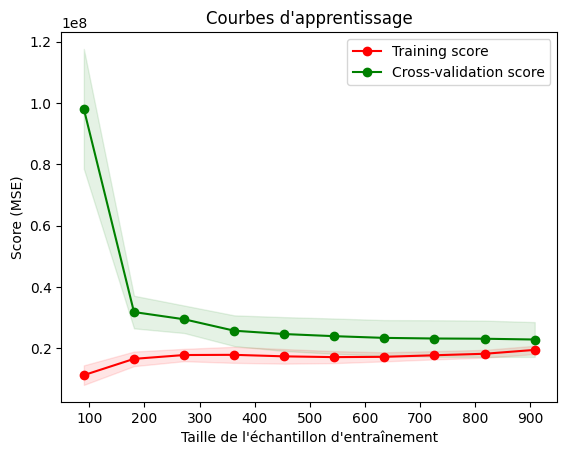

In [6]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

# Définir les intervalles pour la taille de l'échantillon d'entraînement
train_sizes = np.linspace(0.1, 1.0, 10)

# Calculer les courbes d'apprentissage
train_sizes, train_scores, validation_scores = learning_curve(
    grid.best_estimator_, X_train, y_train, train_sizes=train_sizes, cv=5, scoring='neg_mean_squared_error'
)

# Calculer la moyenne et l'écart-type des scores d'entraînement et de validation
train_scores_mean = -train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
validation_scores_mean = -validation_scores.mean(axis=1)
validation_scores_std = validation_scores.std(axis=1)

# Tracer les courbes d'apprentissage
plt.figure()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.title("Courbes d'apprentissage")
plt.xlabel("Taille de l'échantillon d'entraînement")
plt.ylabel("Score (MSE)")
plt.legend(loc="best")
plt.show()
